<a href="https://colab.research.google.com/github/Viny2030/sklearn/blob/main/plotcaliforniahousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
Improve your data science workflow with skops
=============================================
"""

# %%
# Introduction
# ------------

# %%
# The goal of this exercise is to go through a semi-realistic data science
# and machine learning task and develop a practical solution for it. We
# will learn about the following topics:

# %%
# - Perform *exploratory data analysis*
# - Do some non-trivial *feature engineering*
# - Explain how the feature engineering informs the *choice of machine
#   learning model* and vice versa
# - Show how to make use of a couple of *advanced scikit-learn* features
#   and explain why we use them - Create a *model card* that provides
#   useful information about the model
# - Share the model by uploading it to the *Hugging Face Hub*

# %%
# Imports
# -------

# %%
# Before we start, we need to import a couple of packages. In particular,
# to run this code, we need to have the following 3rd party packages: jupyter,
# matplotlib, pandas, scikit-learn, skops.

# %%
# So if you want to run this exercise yourself and these packages are not
# installed yet in your Python environment, you should run:

# %%
# ``python -m pip install jupyter matplotlib pandas scikit-learn skops``

# %%

In [1]:
import os
from operator import itemgetter
from pathlib import Path
from tempfile import mkdtemp

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from matplotlib.patches import Rectangle
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)

In [3]:
from sklearn.inspection import DecisionBoundaryDisplay, permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import get_scorer
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeRegressor

In [5]:
!pip install skops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.4 MB/s eta 0:00:00


In [6]:
import skops
from skops import card, hub_utils
from skops import io as sio

In [7]:
plt.style.use("seaborn-v0_8")

# %%
# Analyzing the dataset
# ---------------------

# %%
# Fetch the data
# ~~~~~~~~~~~~~~

# %%
# First of all, let’s load our dataset. For this exercise, we use the
# California Housing dataset. It can be downloaded using the function from
# scikit-learn. If called the first time, this function will download the
# dataset, on subsequent calls, it will load the cached version.

# %%
# We will make use of the option to set , which will return the data as a
# pandas. This will make our much easier than working with a numpy array, which
# it would return otherwise.

# %%

In [8]:
data = fetch_california_housing(as_frame=True)

# %%
# The dataset comes with a description. If not already familiar with the
# dataset, it’s always a good idea to read the included description.

# %%

In [9]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

# %%
# Exploratory data analysis
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# %%
# Now it’s time to start exploring the dataset. First of all, let’s
# determine what the target for this task is:

# %%

In [10]:
target_col = data.target_names[0]
print(target_col)

MedHouseVal


# %%
# The target column is called "MedHouseVal" and from the
# description, we know it designates "the median house value for
# California districts, expressed in hundreds of thousands of
# dollars".

# %%
# Next let’s extract the actual data, which, as mentioned, is contained in
# a pandas ``DataFrame``:

# %%

In [11]:
df = data["frame"]

# %%
# For now, we leave the target variable inside the ``DataFrame``, as
# this will facilitate the upcoming analysis. Once we get to modeling, we
# should of course separate the target data to avoid accidentally training
# on the target.

# %%
# Let’s peak at some properties of the data.

# %%

In [12]:
df.shape

# %%
df.head()

# %%
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


# %%
# Scaling the target
# ^^^^^^^^^^^^^^^^^^

# %%
# Before we continue working with the data, let’s do a small adjustment.
# From the description, we know that the target variable, the median house
# price, is expressed in units of $100,000. For our first row, that means
# the actual price is $52,600, not $52.6 (which would be very cheap, even
# for 1990).

# %%
# In theory, the unit should not matter for our work, but let’s still
# convert it to $. This is because when we search for general solutions to
# this task, most people work with $ values. If we use a different unit
# here, it makes comparison to these results unnecessarily difficult.

# %%

In [13]:
df["MedHouseVal"] = 100_000 * df["MedHouseVal"]

# %%
# Differences to other versions of the dataset
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# %%
# Another notable difference in this particular dataset is that some
# columns are already averages. E.g. we find the column AveRooms, which is
# the average number of rooms per household of this group of houses. In
# other versions of the dataset (like the one on
# `kaggle <https://www.kaggle.com/datasets/camnugent/california-housing-prices>`__),
# we will, however, find the total number of rooms and the number of
# households. So here, some feature engineering was already performed by
# calculating the averages. This is fine and we can keep it like this.

# %%
# Missing values
# ^^^^^^^^^^^^^^

# %%
# Furthermore, in the description, we find: Missing Attribute Values:
# None. This probably means that there are no missing values, but let’s
# check ourselves just to be certain:


# %%

In [14]:
df.isna().any()

,0
MedInc,False
HouseAge,False
AveRooms,False
AveBedrms,False
Population,False
AveOccup,False
Latitude,False
Longitude,False
MedHouseVal,False


# %%
# Indeed, the dataset contains no missing values. If it did, we could have
# made use of the `imputation features of
# sklearn <https://scikit-learn.org/stable/modules/impute.html>`__.

# %%
# Distributions of variables
# ^^^^^^^^^^^^^^^^^^^^^^^^^^

# %%
# It’s always useful to take a look at the distributions of our variables.
# This is best achieved by visual inspection, which is why we will create
# a couple of plots. For this exercise, we use matplotlib for plotting,
# since it’s very powerful and popular. It also works well with pandas.

# %%
# First we want to focus on the following columns:


# %%

In [15]:
cols = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup"]

# %%
# These are all our feature variables except for the geospatial features,
# "Longitude" and "Latitude". We will analyze those more
# closely later.

# %%
# The most basic plot we can create for analyzing the distribution is the
# histogram. So let’s plot the histograms for each of those variables.

# %%
# Before we take a closer look at the data, just a few words on how we
# create the plots. Since we have 6 variables, it would be convenient to
# plot the data in a 3x2 grid. That’s why createa matplotlib figure with 6
# subplots, using 3 rows and 2 columns. The resulting ``axes``
# variable is a 3x2 numpy array that contains the individual subplots.

# %%
# We also want to make use of the pandas plotting method, which we can
# call using ``df.plot``. This uses matplotlib under the hood, so
# it’s not strictly needed. But the nice thing is that pandas provides
# some extra convenience, e.g. by automatically labeling the axes.

# %%
# In order for pandas to plot onto our created figure with its subplots, we pass
# the ``X`` argument to ``df.plot``. This tells pandas to plot onto this
# subplot, instead of creating a new plot. Another little trick is to
# ``flatten`` the subplot array while looping over it. That way, we don’t need
# to take care of looping over its two dimensions separately.

# %%
# Finally, we should also call ``plt.tight_layout()`` to prevent the subplots
# from overlapping.

# %%

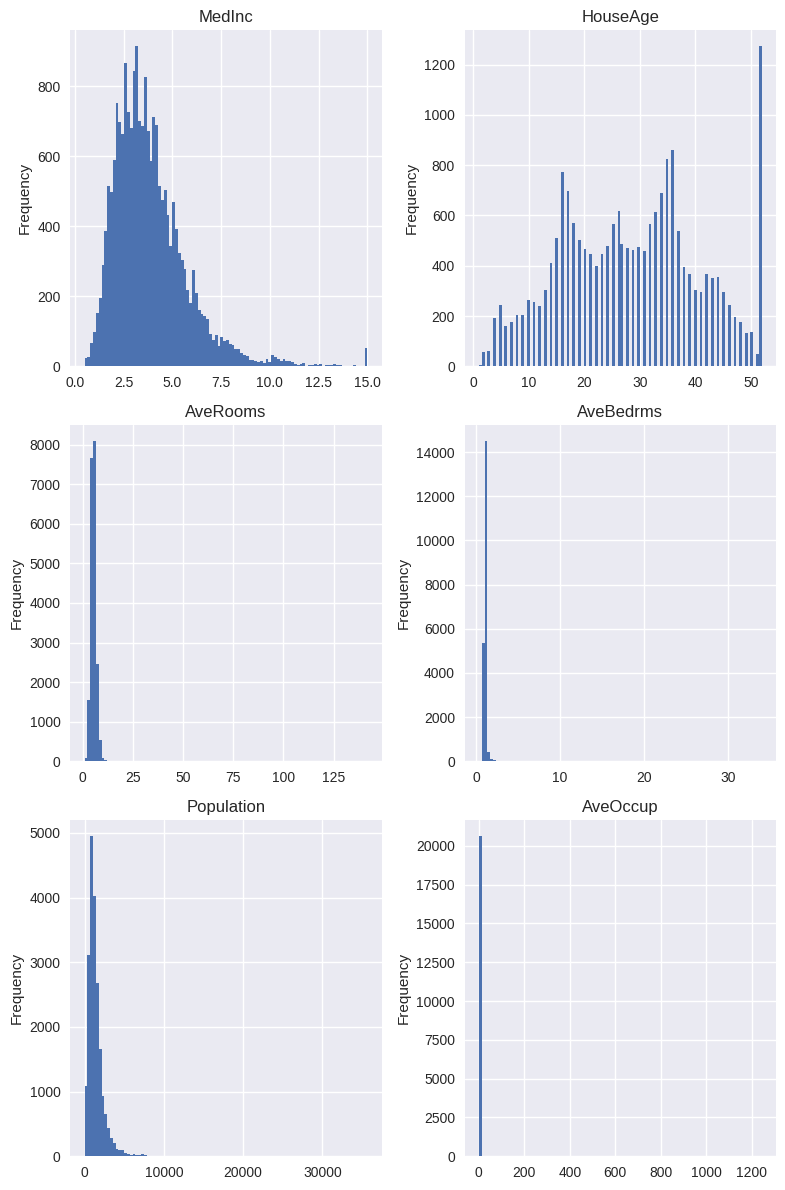

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
for ax, col in zip(axes.flatten(), cols):
    df.plot(kind="hist", y=col, bins=100, title=col, ax=ax, legend=None)
plt.tight_layout()


# %%
# Already, we can make some interesting observations about the data. For
# "MedInc", but especially for "HouseAge", we see a large
# bin to the right side of the distribution. This could be an indicator
# that values might have been clipped. Let’s look at "HouseAge"
# more closely:

# %%

In [17]:
df["HouseAge"].describe()

,HouseAge
count,20640.000000
mean,28.639486
std,12.585558
min,1.000000
25%,18.000000
50%,29.000000
75%,37.000000
max,52.000000


In [18]:
# %%
df["HouseAge"].value_counts().head().to_frame("count")

,count
HouseAge,
52.0,1273
36.0,862
35.0,824
16.0,771
17.0,698


# %%
# So we see that there are 1273 samples with a house age of 52, which also
# happens to be the maximum value. Could this be coincidence? Perhaps, but
# it’s unlikely. The more likely explanation is that houses that were
# older than 52 years were just clipped at 52. In the context of the
# problem we’re trying to solve, this doesn’t make a big difference, so we
# will just accept this peculiarity.

# %%
# Next we can see in the histograms above that for "AveRooms", "AveBedrms",
# "Population", and "AveOccup", the bins are squished to the left. This means
# that there is a fat right tail in the distribution, which might be
# problematic. When looking at the description, we find a potential explanation:

# %%
# An household is a group of people residing within a home. Since the
# average number of rooms and bedrooms in this dataset are provided per
# household, these columns may take surpinsingly large values for block
# groups with few households and many empty houses, such as vacation
# resorts.


# %%
# So what should we do about this? For the purpose of plotting the values,
# we should certainly think about removing these extreme values. For the
# machine learning model we will train later, the answer is: it depends.
# When we use a model like linear regressions or a neural network, these
# extreme values can be problematic and it would make sense to scale the
# values to have a more uniform or normal distribution. When using
# decision tree-based models, these exteme values are not problematic
# though. A decision tree will split the data into those samples that are
# less than or greater than a certain value – it doesn’t matter how much
# smaller or greater the values are. Since we will actually rely on
# tree-based models, let’s leave the data as is (except for plotting).

# %%
# When it comes to plotting, how can we deal with these extreme values? We
# could scale the data, e.g. by taking a ``log``. This can be
# achieved by passing ``logx=True`` to the plotting method. However,
# the log scale makes it harder to read the actual values of the data.
# Instead, let’s use a more brute force approach of simply excluding that
# 1% largest values. For this, we calculate the 99th percentile of the
# values and exclude all values that exceed that percentile. Apart from
# that change, the plots are the same as above:


# %%

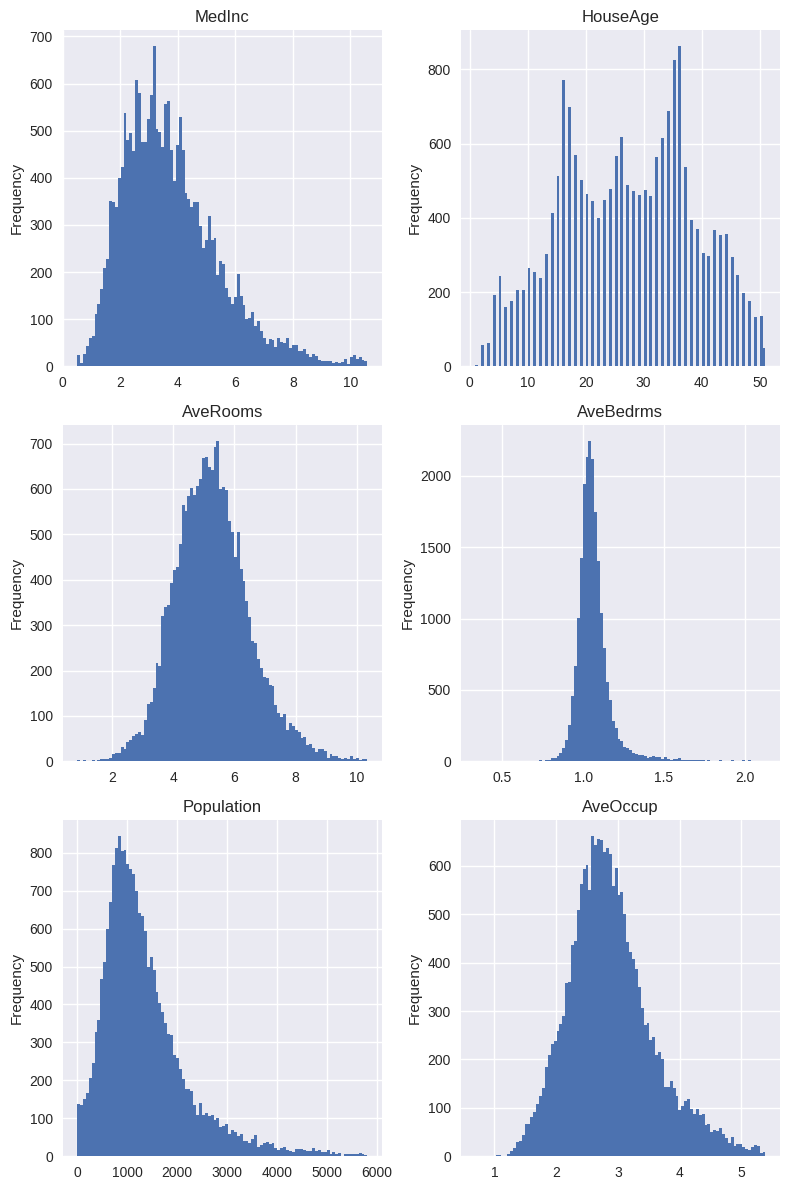

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
for ax, col in zip(axes.flatten(), cols):
    quantile = df[col].quantile(0.99)
    mask = df[col] < quantile
    df[mask].plot(kind="hist", y=col, bins=100, title=col, ax=ax, legend=None)
plt.tight_layout()


# %%
# With extremely large values excluded, we can see that the variables are
# distributed in a very reasonable fashion. With a bit of squinting, the
# distributions almost look Gaussian, which is what we like to see.

# %%
# Correlations with the target
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# %%
# Now it’s time to look at how our features are correlated with our
# target. After all, we plan on predicting the target based on the
# features, and even though correlation with a target is not necessary for
# a feature to be helpful, it’s a strong indicator. As before, we will
# filter out extreme values.

# %%

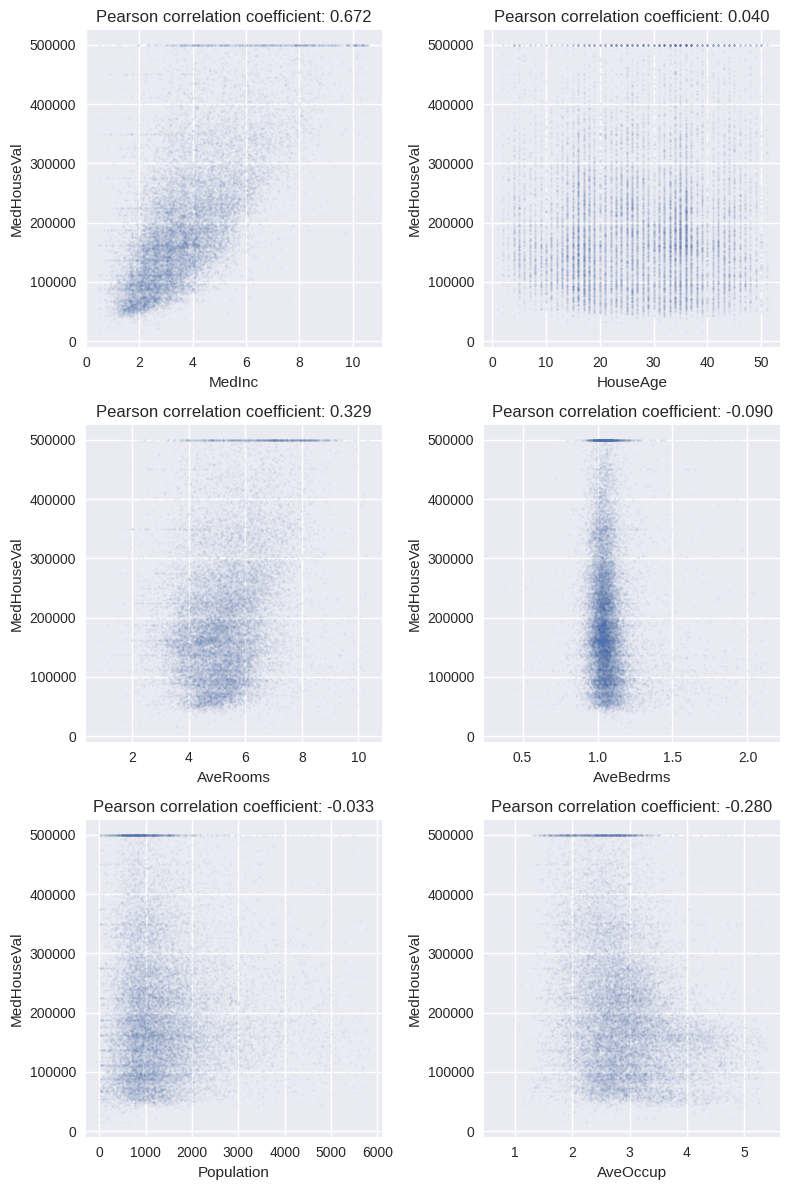

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
for ax, col in zip(axes.flatten(), cols):
    quantile = df[col].quantile(0.99)
    df_subset = df[df[col] < quantile]
    correlation = df_subset[[col, target_col]].corr().iloc[0, 1]
    title = f"Pearson correlation coefficient: {correlation:.3f}"
    df_subset.plot(
        kind="scatter", x=col, y=target_col, s=1.5, alpha=0.05, ax=ax, title=title
    )
plt.tight_layout()

# %%
# Again, let’s try to improve our understanding of the dataset by visually
# inspecting the outcomes. The first thing to notice is perhaps that our
# target, the "MedHouseVal", seems to be clipped at $500,000. Let’s
# remember that and return to it later.

# %%
# Next we should notice that apart from "MedInc", none of the variables seem to
# strongly correlate with the target. If this were a real business problem to
# solve at a company, now would be a good time to get ahold of a domain expert
# and verify that this is expected.

# %%
# We also calculate the Pearson correlation coefficient and show it in the plot
# titles, but honestly, it cannot tell us much we can’t already determine by
# visual inspection.

# %%
# Geospatial features
# ^^^^^^^^^^^^^^^^^^^

# %%
# Now it’s time to take a look at the geospatial data, namely
# "Longitude" and "Latitude". We already know that our
# dataset is limited to the US state of California, so we should expect
# the data to be exclusively in that area.

# %%
# Before actually plotting the data, let’s take a quick brake and form a
# hypothesis. We can reasonably expect that housing prices should be high in
# metropolitan areas. For California, this could be around Los Angeles and the
# bay area. Does our data reflect that?

# %%
# To answer this question, we can plot the target variable as a function of its
# coordinates. Since we deal with longitude and latitude, and since it’s
# reasonably likely that the Earth is not flat, it is not quite correct to just
# plot the data as is. It would be more accurate to use a projection to map the
# coordinates to 2 dimensions, e.g. by using `geopandas
# <https://geopandas.org/en/stable/>`__.

# %%
# For our purposes, however, despite the size of California, we should be able
# to get away without using any projections. So let’s simplify our life by just
# using raw longitude and latitude.

# %%

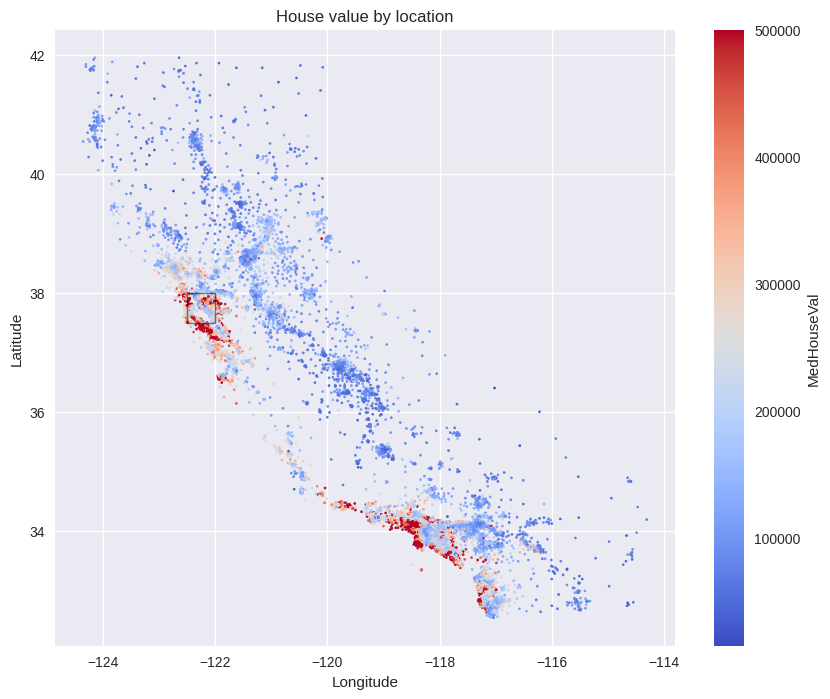

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
df.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    c=target_col,
    title="House value by location",
    cmap="coolwarm",
    s=2.5,
    ax=ax,
)
inset = (-122.5, 37.5)
rect = Rectangle(
    inset, 0.5, 0.5, linewidth=1, edgecolor="k", facecolor="none", alpha=0.5
)
ax.add_patch(rect)


# %%
# This is an interesting plot. Let’s try to draw some conclusions.

# %%
# First of all, we see that the locations are not evenly distributed across the
# state. There are big patches without any data, especially on the eastern side
# of the state, whereas the western coast is more highly populated. Data is also
# more sparse in the mountainous area, where we can expect population density to
# be lower.

# %%
# Regarding our initial hypothesis about house prices, we can indeed find
# clusters of high prices exceeding $400,000, whereas the majority of the data
# points seem to fall below $50,000. After checking on a map, the high priced
# areas seem to be indeed around Los Angeles and the bay area, but there are
# other high priced areas as well, e.g. in San Diego.

# %%
# From this, we can already start thinking about some possibly interesting
# features. Some variations of this dataset contain, for instance, a
# variable indicating the closeness to the Ocean, since it seems that
# areas on the coast are more expensive on average. Another interesting
# feature could be the distance to key cities like Los Angeles and San
# Francisco. Here distance should probably be measured in terms of how
# long it takes to drive there by car, not just purely in terms of spatial
# distance – after all, most people only have a car and not a helicopter.

# %%
# As you can imagine, getting this type of data requires additional data
# sources and probably a lot of extra work. Therefore, we won’t take this
# route. However, we will develop specific geospatial features below,
# which will probably capture most of the information we need for this
# task.

# %%
# Before advancing further, we should zoom into the geospatial data, given how
# difficult it is to see details on the plot above. For that, we take a small
# inset of that figure (marked with a rectangle), which seems to be an
# interesting spot, and plot it below:


# %%

(37.5, 38.0)

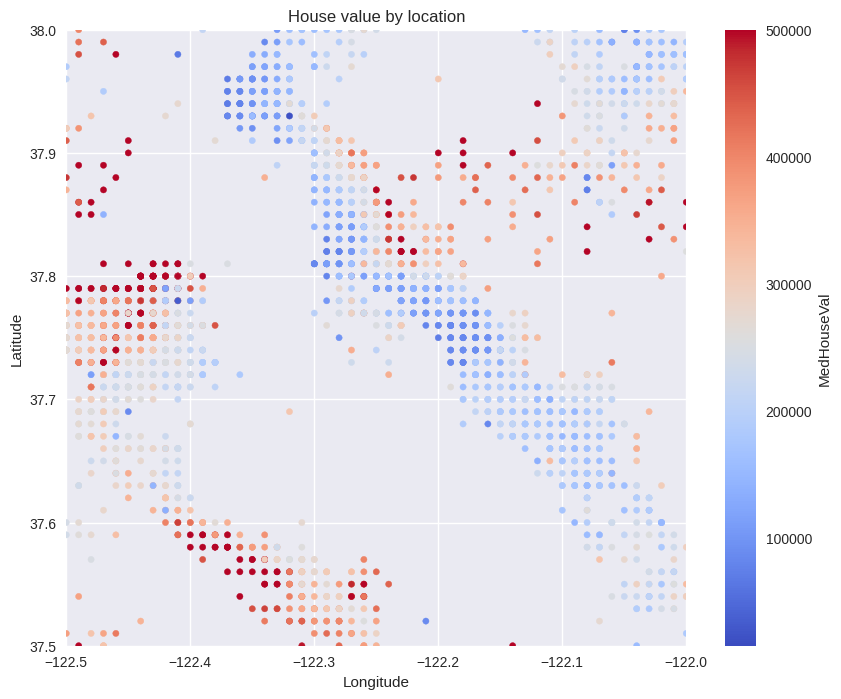

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
df.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    c=target_col,
    title="House value by location",
    cmap="coolwarm",
    ax=ax,
)
ax.set_xlim([inset[0], inset[0] + 0.5])
ax.set_ylim([inset[1], inset[1] + 0.5])


# %%
# What can we take away from this plot? First of all, it shows that even
# though there are clear patterns of high and low price areas, they can
# also be situated very close to each other. This could already give us
# the idea that prices in the *neighborhood* could be a strong predictor
# for our target variable, but the size of the neighborhood should not be
# too large.

# %%
# Another interesting pattern we see is that the data points are distributed on
# a regular grid. This is not what we would expect if, say, each point
# represented a community, town, or city, since those are not evenly spaced.
# Instead, this indicates that the data was aggregated with a certain spatial
# resolution. Also, given the gaps, it could be reasonable to assume that data
# points with too few houses were removed from the dataset, maybe for privacy
# concerns. Again, talking to a domain expert would help us better understand
# the reason.

# %%
# Anyway, we should keep this regular spatial distribution in mind for later.

# %%
# A final observation about the coordinates. We might believe that for a
# given longitude and latitude, there is exactly one sample (or 0, if not
# present). However, there are duplicates when it comes to coordinates, as
# shown below:

# %%

In [23]:
df.duplicated(["Longitude", "Latitude"]).sum()

8050

In [24]:
# %%
# These rows are not completely duplicated, however, as there are no
# duplicates when considering all columns:

# %%
df.duplicated().sum()

0

In [25]:
# %%
# At the most extreme end, we find coordinates with 15 samples:

# %%
df[["Longitude", "Latitude"]].value_counts().to_frame("count").reset_index().head()


,Longitude,Latitude,count
0,-122.41,37.80,15
1,-122.44,37.78,11
2,-122.42,37.80,11
3,-122.43,37.77,10
4,-122.27,37.85,10


In [26]:
# %%
# Overall, for more than a third of coordinates, we find more than one
# data point:

# %%
(df[["Longitude", "Latitude"]].value_counts() > 1).mean()


0.3457505957108816

<Axes: ylabel='Frequency'>

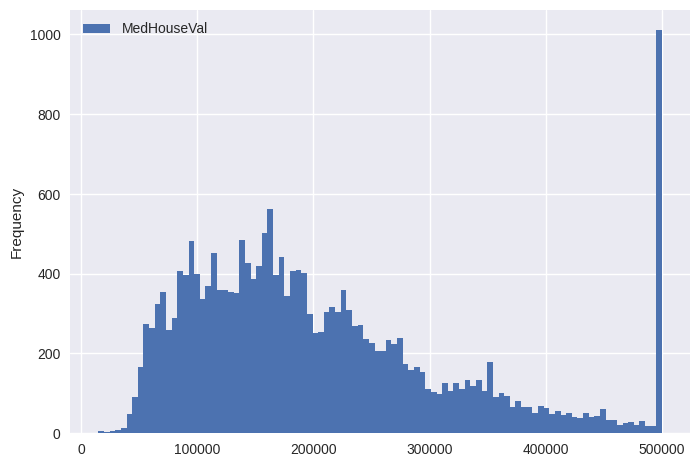

In [27]:
# %%
# Again, if this were a real business case, we should investigate this
# further and find someone who can explain this peculiarity in the data.
# One possible explanation could be that those are samples for the same
# location but from different points in time. If this were true, we would
# have to make adjustments, e.g. by considering the time when we make a
# train/test split. But we have no possibility to verify that time is the
# explanation. As is, we just accept this fact and keep it in mind for
# later.

# %%
# Target variable
# ^^^^^^^^^^^^^^^

# %%
# Finally, we should not forget to take a look at the target variable
# itself. Again, let’s start with plotting its disstribution:

# %%

df.plot(kind="hist", y=target_col, bins=100)

In [28]:
# %%
# As we have already established earlier, we find that the target data
# seems to be clipped. Let’s take a closer look:

# %%
df[target_col].value_counts().head()


,count
MedHouseVal,
500001.0,965
137500.0,122
162500.0,117
112500.0,103
187500.0,93


In [29]:
# %%
# Is it possible that this would occur naturally in the data? Sometimes,
# we may find strange patterns. To give an example, if there was a law
# that sales above a certain value are taxed differently, we could expect
# prices to cluster at this value. But this appears to be very unlikely
# here, especially since prices seem to be rounded to the closest $100, as
# we can see from the following probe:

# %%
(
    (df[target_col] % 100)
    .round()
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": f"{target_col} % $100", target_col: "count"})
)

,count,count
0,0.0,18396
1,100.0,1275
2,1.0,965
3,99.0,4


In [30]:
# %%
# So if we take the modulo of the house price to $100, we find that it it’s
# almost always 0 (well, we see a few 100’s, but that’s just a rounding issue).
# Then we see 965 prices ending in , which are exactly those 965 samples we
# found with a price of $100,001. Finally, we see 4 prices ending in 9. Let’s
# take a look:

# %%
df[np.isclose(df[target_col] % 100, 99)][target_col].to_frame()

,MedHouseVal
2521,14999.0
2799,14999.0
9188,14999.0
19802,14999.0


In [31]:
# %%
df[target_col].min()


14999.000000000002

In [32]:
# %%
# So these four samples actually correspond to the lowest prices in the dataset.
# Therefore, it is very reasonable to assume that the dataset creators decided
# to set a maximum price of $500,000 and a minimum price of $15,000, with all
# prices falling outside that range being set to the max/min price +/- . For the
# prices within the range, they decided to round to $100.

# %%
# When it comes to our task of predicting the target, this clipping could
# be dangerous. We cannot know by how much the actual price was clipped,
# especially when it comes to high prices. For a machine learning model,
# it could become extraordinarily hard to predict these high prices,
# because even though the features may, for instance, indicate a price of
# $1,000,000 for one sample and $500,100 for another, the model is supposed to
# predict the same price for both. For this reason, let us remove the
# clipped data from the dataset. Whether that’s a good idea will in
# reality depend on the use case that we’re trying to solve.

# %%
# Training a machine learning model
# ---------------------------------

# %%
# Now that we have gained a good understanding of our data, we move to the
# next phase, which is training a machine learning model to predict the
# target.

# %%
# Remove samples with clipped target data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# %%
# As a first step, we will remove the samples where the target data has
# been clipped, as discussed above.


# %%
mask = (15_000 <= df[target_col]) & (df[target_col] <= 500_000)
print(
    f"Discarding {(1 - mask).sum()} ({100 * (1 - mask.mean()):.1f}%) of rows because"
    " the target is clipped."
)


Discarding 969 (4.7%) of rows because the target is clipped.


In [33]:
# %%
# Train/test split
# ~~~~~~~~~~~~~~~~

# %%
# Then we should split our data into a training and a test set. As every
# data scientist should know, we need to evaluate the data on a different
# set than we use for training. It would be even better if we created
# three sets of data, train/valid/test, and only used the test set at the
# very end. For the training part, we could use cross-validation to get
# more reliable results, given that our dataset is not that big. For the
# purpose of this exercise, we make our lifes simple by only using a
# single train/test split though.

# %%
# As to the split itself, we just split the data randomly using sklearn’s
# ``train_test_split``. There is nothing in the data that would
# suggest we need to perform a non-random split but again, this will vary
# from use case to use case. Note that we set the ``random_state``
# to make the results reproducible.


# %%
df_train, df_test = train_test_split(df[mask], random_state=0)

# %%
df_train.shape, df_test.shape

((14753, 9), (4918, 9))

In [34]:
# %%
# After performing the split, it is now a good time to remove the target
# data from the rest of the ``DataFrame``, so that we don’t run the
# risk of accidentally training on the target. We use the ``pop``
# method for that.


# %%
y_train = df_train.pop(target_col).values
y_test = df_test.pop(target_col).values


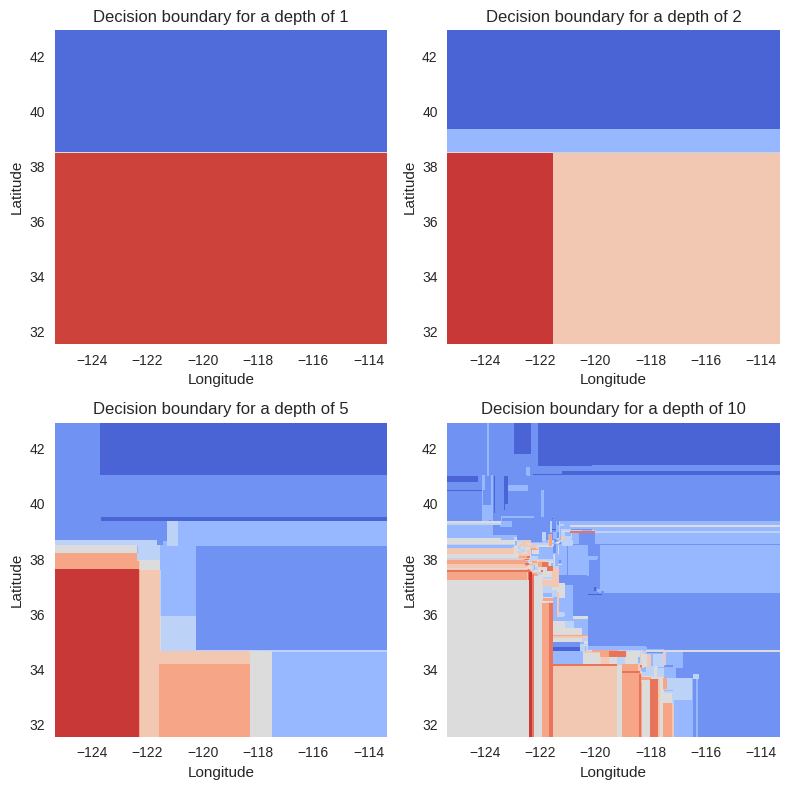

In [35]:
# %%
# Feature engineering
# ~~~~~~~~~~~~~~~~~~~

# %%
# Now let’s get to the feature engineering part. Here it’s worth it to
# think a little bit about what type of ML model we plan to use and how
# that decision should inform the feature engineering.

# %%
# In general, we know that for tabular tasks as this one, ensembles of decision
# trees perform exceptionally well, without the need for a lot of tuning.
# Examples would be random forest or gradient boosting. We should not try to
# challenge this conventional wisdom, this class of models is an excellent
# choice for this task as well. There is, however, a caveat. Let’s explore it
# more closely.

# %%
# We know that the geospatial features are crucial for our task, since we saw
# that there is a very strong relationship between the house price of a given
# sample and the house price of its neighbors. On the other hand, we saw that
# all the other variables, safe for "MedInc", are probably not strong
# predictors. We thus need to ensure we can make the best use of "Longitude" and
# "Latitude".

# %%
# If we use a tree-based model, can we just input the longitude and
# latitude as features and be done with it? In theory, this would indeed
# work. However, let’s remember how decision trees work. According to a
# certain criterion, they split the data at a certain value. As an
# example, we could find that the first split of a tree is to split the
# data into samples with latitude less than 34 and latitude greater than
# 34, which is roughly the median. Each time we split the data along
# longitude and latitude, we can imagine the map being devided into four
# quadrants. So far, so good.

# %%
# The problem now comes with the patchiness of the data. Looking again at the
# house value by location plot further above, we can immediately see that we
# would need *a lot of splits* to capture the neighborhood relationship we find
# in the data. How many splits would we need? Let’s take a look.

# %%
# To study this question, we will take the ``DecisionTreeRegressor`` from
# sklearn and fit it on the longitude and latitude features. The number of
# splits is bounded by the ``max_depth`` parameter. So for each level of depth,
# the tree splits the data once. That is, for a depth of 10, we get
# ``2**10=1024`` splits (in reality, the number could be lower, depending on the
# other parameters of the tree).

# %%
# To get a feeling of what that means in practice, let us first fit 4 decision
# trees, using ``max_depth`` values of 1, 2, 5, and 10. Then we plot the
# *decision boundary* of the tree after fitting it. We use sklearn’s
# `DecisionBoundaryDisplay
# <https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html>`__
# to plot the data. Here is what we get:

# %%
_, axes = plt.subplots(2, 2, figsize=(8, 8))
max_depths = [1, 2, 5, 10]
for max_depth, ax in zip(max_depths, axes.flatten()):
    dt = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    dt.fit(df_train[["Longitude", "Latitude"]], y_train)
    DecisionBoundaryDisplay.from_estimator(
        dt,
        df_train[["Longitude", "Latitude"]],
        cmap="coolwarm",
        response_method="predict",
        ax=ax,
        xlabel="Longitude",
        ylabel="Latitude",
        grid_resolution=1000,
    )
    ax.set_title(f"Decision boundary for a depth of {max_depth}")
plt.tight_layout()

Text(0.5, 1.0, 'Decision boundary of KNN')

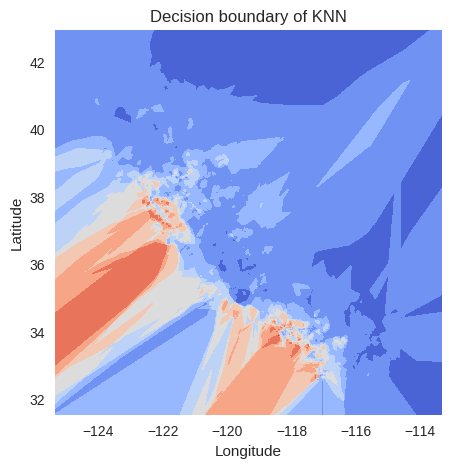

In [36]:
# %%
# As we have described, with a depth of 1, we split our map in half, with
# two splits, we get 4 quadrants. This is shown in the first row.

# %%
# In the second row, we see the outcomes for depths of 5 and 10. Especially for
# 10, we see this resulting in quite a few "boxes" that represent neighborhoods
# with similar prices. But even with this relatively high number of splits, the
# "resolution" of the resulting map is quite bad, lumping together many areas
# with quite different prices.

# %%
# So what can we do about that? The easiest solution would be to increase
# the ``max_depth`` parameter to such a high value that we can
# actually model the spatial relationship well enough. But this has some
# disadvantages. First of all, a high ``max_depth`` parameter can
# result in overfitting on the training data. Remember that we also have
# other variables that we want to include, the tree will also split on
# those. Second of all, a high ``max_depth`` makes the model bigger
# and slower. Depending on the application, this could be a problem for
# productionizing the model.

# %%
# Another solution is that we could use an ensemble of decision trees. The
# result of that will be multiple maps as those above layered on top of each
# other. Although this will certainly help, it’s still not a perfect solution,
# since it would still require quite a lot of trees to achieve a good
# resolution. Imagine a dataset with much more samples and much more
# fine-grained data, we would need a giant ensemble to fit it.

# %%
# At the end of the day, we have to admit that decision tree-based models
# are just not the best fit when it comes to modeling geospatial
# relationships. Can we think of a model that is better able to model this
# type of data? Why, of course we can. The k-nearest neighbor (KNN) family
# of models should be a perfect fit for this, since we want to model
# *neighborhood* relationships. To see this in action, let’s again plot
# the decision boundaries, this time using the
# ``KNeighborsRegressor`` from sklearn:


# %%
# this controls the level of parallelism, feel free to set to a higher number
N_JOBS = 1

# %%
_, ax = plt.subplots(figsize=(5, 5))
knn = KNeighborsRegressor(n_jobs=N_JOBS)
knn.fit(df_train[["Longitude", "Latitude"]], y_train)
DecisionBoundaryDisplay.from_estimator(
    knn,
    df_train[["Longitude", "Latitude"]],
    cmap="coolwarm",
    response_method="predict",
    ax=ax,
    xlabel="Longitude",
    ylabel="Latitude",
    grid_resolution=1000,
)
ax.set_title("Decision boundary of KNN")


In [37]:
# %%
# Now if we compare this to the decision boundaries of the decision trees, even
# with a depth of 10, it’s a completely different picture. The KNN model, by its
# very nature, can easily model very fine grained spatial differences. The
# granularity will depend on the ``k`` part of the name, which indicates the
# number of neighbors that are used to make the prediction. At the one extreme,
# for ``k=1``, we would only consider a single data point, resulting in a very
# spotty map. At the other extreme, when ``k`` is the size of the total dataset,
# we would simply average across all data points. Choosing a good value for
# ``k`` is thus important.

# %%
# We will now go into more details of the KNN model. If you’re wondering
# how this is related to feature engineering, it will become clear later,
# as will actually use the KNN model for the purpose of creating a new
# feature. So please be patient.

# %%
# Aside: distance metrics
# ^^^^^^^^^^^^^^^^^^^^^^^

# %%
# Before we explore this problem further, let’s talk about distance
# metrics. For a KNN model to work, we need to define the distance metric
# it uses to determine the closest neighbors. By default,
# ``KNeighborsRegressor`` uses the Euclidean distance.

# %%
# Earlier, we saw that our data points are distributed on a regular grid.
# This means, if we take a specific sample, and if we assume that it’s
# neighboring spots are not empty, there should be 4 neighbors at exactly
# the same distance, namely the neighbors directly north, east, south, and
# west. Similarly, neighbors 5 to 8, in the directions NE, SE, SW, and NW,
# should also have the exact same distances.

# %%
# Let’s check if this is true. For this, we fit a KNN and then use the
# ``kneighbors`` method to return the closest neighbors.


# %%
knn = KNeighborsRegressor(20)
knn.fit(df[["Longitude", "Latitude"]], df[target_col])

KNeighborsRegressor(n_neighbors=20)

In [38]:
# %%
distances = knn.kneighbors(
    df[["Longitude", "Latitude"]].iloc[[123]], return_distance=True
)[0].round(5)
print(distances)

[[0.      0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01
  0.01    0.01    0.01    0.01    0.01414 0.01414 0.01414 0.01414 0.01414
  0.01414 0.01414]]


In [39]:
# %%
# So we find indeed that the distances are discrete, with many samples
# having exactly the same distance like 0.01. The closest neighbor has a
# distance of 0 – this is not surprising, as this the sample itself.
# However, unlike what we expected, we don’t find exactly four equally
# distant closest neighbors. Instead, for this sample we find 12 samples
# with a distance of exaclty 0.01 (i.e. exactly one step to the north,
# east, south, or west). How come?

# %%
# Remember from earlier that we found duplicate coordinates in our data?
# This is most likely such a case. So let’s remove duplicates and
# determine the distances again:


# %%
knn = KNeighborsRegressor(20)
df_no_dup = df.drop_duplicates(["Longitude", "Latitude"]).copy()
knn.fit(df_no_dup[["Longitude", "Latitude"]], df_no_dup[target_col])


KNeighborsRegressor(n_neighbors=20)

In [40]:
# %%
distances = knn.kneighbors(
    df[["Longitude", "Latitude"]].iloc[[123]], return_distance=True
)[0].round(5)
print(distances)

[[0.      0.01    0.01    0.01    0.01    0.01414 0.01414 0.01414 0.01414
  0.02    0.02    0.02    0.02    0.02236 0.02236 0.02236 0.02236 0.02236
  0.02236 0.02828]]


In [41]:
# %%
# This looks much better. Now we find exactly 4 neighbors tied for the
# closest distance, 4 tied for the second closest distance, etc.

# %%
# The same thing should become even clearer when we change the metric from
# Euclidean to Manhattan distance. In this context, the Manhattan distance
# basically means how far two points are from each other, if we can only
# take steps along the north-south or east-west axis. To calculate this
# metric, we can set the ``p`` parameter of
# ``KNeighborsRegressor`` to 1:

# %%
knn = KNeighborsRegressor(20, p=1)
knn.fit(df_no_dup[["Longitude", "Latitude"]], df_no_dup[target_col])


KNeighborsRegressor(n_neighbors=20, p=1)

In [42]:
# %%
distances = knn.kneighbors(
    df[["Longitude", "Latitude"]].iloc[[123]], return_distance=True
)[0].round(5)
print(distances)

[[0.   0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03
  0.03 0.03 0.03 0.03 0.03 0.03]]


In [43]:
# %%
# Again, we find 4 neighbors with a distance of exactly 0.01, as expected.
# For distance 0.02, we actually find 8 neighbors. This makes sense,
# because in Manhattan space, the neighbor north-north of the sample has
# the same distance as the neighbor north-east, etc., as both require two
# steps to be reached.

# %%
# What does this mean for us? There are two important considerations:

# %%
# 1. When we train a KNN model with a ``k`` that’s not exactly equal
#    to 4, 8, etc., we run into some problems. If we take, for instance,
#    ``k=3``, and the 4 closest neighbors are equally close,
#    ``KNeighborsRegressor`` will actually pick an arbitrary set of
#    3 from those 4 possible candidates. This generally something we want
#    to avoid in our ML models. In practice, however, the problem isn’t so
#    bad, because we have duplicates and because some neighbor spots are
#    empty, as we saw earlier. This makes it less likely that many data
#    points exhibit different behavior for a very specific ``k``.
# 2. The second consideration is that we should figure out which metric is
#    best for our use case, Euclidean or Manhattan. If people were
#    traveling by air, Euclidean makes most sense. If they traveled on a
#    rectangular grid (like the streets in Manhattan, hence the name),
#    Manhattan makes more sense. In practice, we have neither of those. So
#    let’s just use what works better!

# %%
# Determining the best hyper-parameters for the KNN model
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# %%
# With all that in mind, let’s try to find good hyper-parameters for our
# KNN regressor. As mentioned, we should check the value for ``k``
# and we should check ``p=1`` and ``p=2`` (i.e. Manhattan and
# Euclidean distance). #

# %%
# On top of those, let’s check one more hyper-parameter, namely
# ``weights``. What this means is that when the model finds the
# ``k`` nearest neighbors, should it simply predict the average
# target of those values or should closer neighbors have a higher weight
# than more remote neighbors? To use the former approach, we can set
# ``weights=’uniform’``, for the latter, we set it to
# ``’distance’``.

# %%
# As for the ``k`` parameter, in sklearn, it’s called
# ``n_neighbors``. Let’s check the values from 1 to 25, as well as
# some higher values, 50, 75, 100, 150, and 200.

# %%
# Regarding the metrics, we use root mean squared error (RMSE). This could
# also be replaced with other metrics, it really depends on the use case.
# Here we choose it because this is the most common one used for this
# dataset, so if we wanted to compare our results with the results from
# others, it makes sense to use the same metrics.

# %%
# (Note: For scoring, we use the ``’neg_root_mean_squared_error’``,
# i.e. the negative RMSE. This is because by convention, sklearn considers
# higher values to be better. For RMSE, however, lower values are better.
# To circumvent that, we just the negative RMSE.)

# %%
# To check all the different parameter combinations and to calculate the
# RMSE out of fold, we rely on sklearn’s ``GridSearchCV``. We won’t
# explain what it does here, since there already are so many tutorials out
# there that discuss grid search. Suffice it to say, this is exactly what
# we need for our problem.

# %%
knn = KNeighborsRegressor()
params = {
    "weights": ["uniform", "distance"],
    "p": [1, 2],
    "n_neighbors": list(range(1, 26)) + [50, 75, 100, 150, 200],
}
search = GridSearchCV(knn, params, scoring="neg_root_mean_squared_error")
search.fit(df_train[["Longitude", "Latitude"]], y_train)




/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 50, 75, 100, 150, 200],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [44]:
# %%
# Fortunately, the grid search only takes a few seconds because the model
# is quick, the dataset size is small, and we only test 120 different
# parameter combinations. If the grid search would take too long, we could
# switch to ``RandomizedSearchCV`` or ``HalvingGridSearchCV``
# from sklearn, or use a Bayesian optimization method from other packages.

# %%
# Now, let’s put the results of the grid search into a pandas
# ``DataFrame`` and inspect the top results.


# %%
df_cv = pd.DataFrame(search.cv_results_)
df_cv.sort_values("rank_test_score")[
    ["param_n_neighbors", "param_weights", "param_p", "mean_test_score"]
].head(10)

,param_n_neighbors,param_weights,param_p,mean_test_score
22,6,uniform,2,-48792.277422
26,7,uniform,2,-48908.663856
18,5,uniform,2,-48939.112420
20,6,uniform,1,-48960.566567
24,7,uniform,1,-49049.354866
30,8,uniform,2,-49125.740942
16,5,uniform,1,-49158.915396
28,8,uniform,1,-49264.347864
34,9,uniform,2,-49299.733688
32,9,uniform,1,-49463.991846


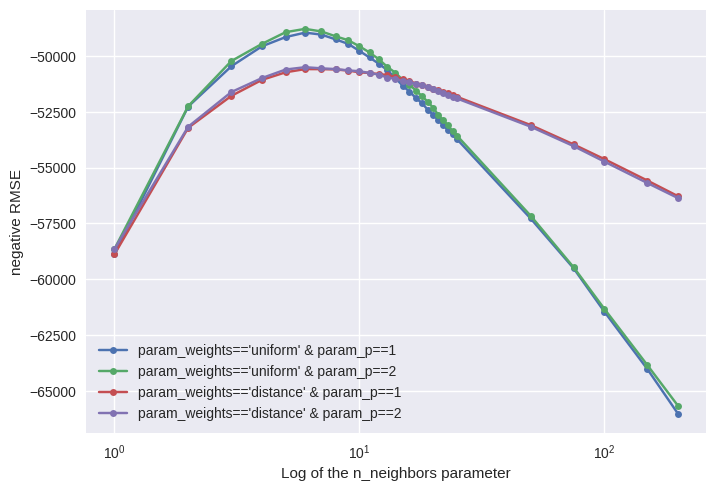

In [45]:
# %%
# Okay, so there is a clear trend for small ``k`` values in the
# range of 5 to 9 to fare better. Also ``’uniform’`` weights seem to
# be clearly superior. When it comes to the distance metric, no clear
# trend is discernable.

# %%
# To get a better picture, it is often a good idea to plot the grid search
# results, instead of just picking the best result blindly, especially if
# the outcome is noisy. For this purpose we will plot four lines, one for
# each combination of ``weights`` and ``p``, all showing the
# RMSE as a function of ``n_neighbors``. Note that we plot
# ``n_neighbors`` on a log scale, because we want to have higher
# resolution for small values.

# %%

fig, ax = plt.subplots()
for weight in params["weights"]:  # type: ignore
    for p in params["p"]:  # type: ignore
        query = f"param_weights=='{weight}' & param_p=={p}"
        df_subset = df_cv.query(query)
        df_subset.plot(
            x="param_n_neighbors",
            y="mean_test_score",
            xlabel="Log of the n_neighbors parameter",
            ylabel="negative RMSE",
            label=query,
            ax=ax,
            marker="o",
            ms=5,
            logx=True,
        )

Text(0, 0.5, 'MedHouseVal')

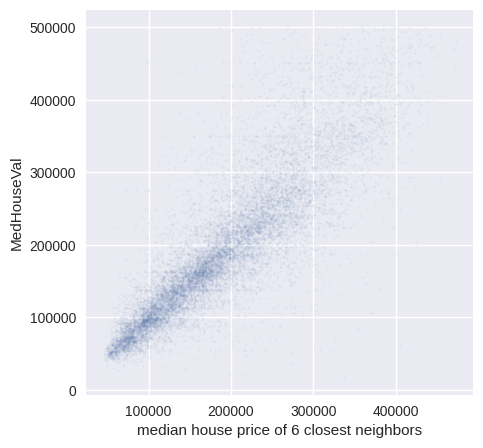

In [46]:
# %%
# So both for ``weights==’uniform’`` and for
# ``weights==’distance’``, we see that ``p==2`` is slightly
# better than, or equally good as, ``p==1``. It will thus be safe to
# use ``p==2``.

# %%
# Furthermore, we see that for low values of ``n_neighbors``, it is
# better to have ``weights==’uniform’``, while for large values of
# ``n_neighbors``, ``weights==’distance’`` is better. This is
# perhaps not too surprising: If we consider a lot of neighbors, many of
# which are already quite far away, we should give lower weight to those
# remote neighbors. When we only look at 5 neighbors, this isn’t necessary
# – their distances will be quite similar anway.

# %%
# Another observation is that the curve for the RMSE as a function of
# ``n_neighbors`` seems to be quite smooth. This tells us two
# things: First of all, the metric isn’t very noisy, at least using the
# 5-fold cross validation that the grid seach uses by default. This is
# good, we don’t want the outcome to be too dependent on randomness.

# %%
# Moreover, we don’t see any strange jumps at ``n_neighbors`` values
# like 4 or 8. If you remember the problem we discussed earlier of
# arbitrary points being chosen when neighbors have the exact same
# distance, this could have been a concern. Since we don’t see it, it’s
# probably not as bad as we might have feared.

# %%
# So now that we have a good idea about what good hyper-parameters for KNN
# are, let’s see how the good the predictions from the model are. For
# this, we plot the true target as a function of the predictions, which we
# calculate out of fold using sklearn’s ``cross_val_predict``.


# %%
knn = KNeighborsRegressor(**search.best_params_)
avg_neighbor_val = cross_val_predict(knn, df_train[["Longitude", "Latitude"]], y_train)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(avg_neighbor_val, y_train, alpha=0.05, s=1.5)
ax.set_xlabel(
    f"median house price of {search.best_params_['n_neighbors']} closest neighbors"
)
ax.set_ylabel(target_col)

In [47]:
# %%
# As we can see, the correlation is quite good between the two. This means
# that our KNN model can explain a lot of the variability in the target
# using only the coordinates, none of the other features. In particular,
# we can easily see that this correlation is much better than the
# correlation of any of the features that we plotted above. **Would it not
# be nice if we could use the KNN predictions as a feature for a more
# powerful model?**

# %%
# Why would we want to use the KNN predictions as a feature for another
# model, instead of just being content with using the KNN as the final
# predictor? The problem is that with KNN, it is very hard to incorporate
# the remaining features. Although we can be sure that those features are
# not as important, they should still contain useful signal to improve the
# model.

# %%
# The reason why it is difficult to include arbitrary features like
# "MedInc" or "HouseAge" into a KNN model is that they are
# on a completely different scale than the coordinates, so we would need
# to normalize all the data. Even then, we know that our other features
# are not very uniformely distributed, which in general is something that
# the KNN benefits from.

# %%
# But even if everything was on the same scale and evenly distributed,
# should we weight a distance of 0.1 in the "MedInc" space the
# same as a distance of 0.1 in "Longitude" space? Probably not. It
# just doesn’t make sense to put two completely measurements into the same
# KNN model.

# %%
# This is why we will use the KNN predictions as a *feature* for more
# appropriate models. This also explains why this is part of the feature
# engineering section. Doing this correctly is not quite trivial, but
# below we will see how we can use the tools that sklearn provides to
# achieve this goal.

# %%
# Training ML models
# ~~~~~~~~~~~~~~~~~~

# %%
# Now that we have gained important insights into the data and also formed
# a plan when it comes to feature engineering, we can start with the
# training of the predictive models.

# %%
# Dummy model
# ^^^^^^^^^^^

# %%
# As a first step, we start with a dummy model, i.e. a model that isn’t
# allowed to learn anything from the input data. Often, it’s a good idea
# to try a dummy model first, as it will give us an idea what the worst
# score is we should expect. If our proper models cannot beat the dummy
# model, it most likely means we have done something seriously wrong.

# %%
# For this dataset, what is the appropriate dummy model? We are trying to
# minimize the root mean squared error. This is the same as trying to
# minimize the mean squared error (the root is just a monotonic
# transformation). And to minimize the mean squared error, if we don’t
# know anything about the input data, requires us to predict the *mean* of
# the target. For our convenience, sklearn provides a
# ``DummyRegressor`` that will do exactly this for us:

# %%
dummy = DummyRegressor()
dummy.fit(df_train, y_train)


DummyRegressor()

In [48]:
# %%
# Note: Even though we pass ``df_train``, the
# ``DummyRegressor`` does not make use of it. We could pass an empty
# ``df`` and the result would be the same.


# %%
-get_scorer("neg_root_mean_squared_error")(dummy, df_test, y_test)

100528.43327419003

In [49]:
# %%
# As a reminder, sklearn only comes with the negative RMSE, so we make it
# positive again at the end.

# %%
# Adding KNN predictions as features
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# %%
# Let’s get to the part where we want to add the predictions of the KNN
# model as features for our final regression model. As we have discussed
# above, we have some good evidence that the KNN predictions are well
# suited to capture the spatial relationship between data points, but KNN
# itself is not good with dealing with the other features, so we want to
# use a model that can deal with those features on top of the KNN
# predictions.

# %%
# Does sklearn offer us a way of adding the predictions of one model as features
# for another model? Indeed it does, this is achieved by using the
# :class:`sklearn.ensemble.StackingRegressor`. To quote from the docs:

# %%
# *Stacked generalization consists in stacking the output of individual
# estimator [sic] and use a regressor to compute the final prediction.
# Stacking allows to use the strength of each individual estimator by
# using their output as input of a final estimator.*

# %%
# In our case, that means that we use KNN for the "individual
# estimator" part and then a different model, like an ensemble of
# decision trees, for the "final esimator".

# %%
# The documentation also states that:

# %%
# *Note that estimators\_ are fitted on the full X while final_estimator\_
# is trained using cross-validated predictions of the base estimators
# using ``cross_val_predict``."*

# %%
# This is important to know. It is crucial that the predictions from the
# KNNs are calculated using ``cross_val_predict``, i.e *out of
# fold*, otherwise, we run into the risk of overfitting. To understand
# this point, let’s take an extreme example. Let’s say we use a KNN with
# ``n_neighbors=1``. If the predictions were calculated *in fold*,
# this KNN would completely overfit on the training data and the
# prediction would be perfect (okay, not quite, since we have duplicate
# coordinates in the data). Then the final model would only rely on the
# seemingly perfect KNN predictions, ignoring all other features. This
# would be really bad. That’s why the "cross-validated
# predictions" part is so crucial.


# %%

# Note: We may be tempted to simply add the new feature to the ``DataFrame``
# like this: ``df['pred_knn'] = knn.predict(df[['Longitude', 'Latitude']])``.

# %%
# However, this is problematic. First of all, we need to make out of fold
# predictions, as explained above. This code snippet would result in
# overfitting. We thus need to calculate the out of fold predictions
# manually, which adds more (errror prone) custom code.

# %%
# Second, let’s assume we want to deploy the final model. When we call it,
# we need to pass all the features, i.e. we would need to generate the KNN
# prediction before passing the features to the model. This requires even
# more custom code to be added, making the whole application even more
# error prone. By sticking with the tools sklearn gives us, we avoid the
# two issues.

# %%
# By default, ``StackingRegressor`` trains the final estimator only
# on the predictions of the individual estimators. However, we want it to
# be trained on all the other features too. This can be achieved by
# setting ``StackingRegressor(..., passthrough=True)``, which will
# *pass through* the original input and concatenate it with the
# predictions from our KNN.

# %%
# Another issue we need to solve is that we want the final estimator to be
# trained on all features, but the KNN is supposed to be only trained on
# longitude and latitude. When we pass all features as ``X``, the
# KNN would be trained on all these features, which, as we discussed,
# wouldn’t be a good idea. If we only pass longitude and latitude as
# ``X``, the final estimator cannot make use of the other features.
# What do we do?

# %%
# The solution here is to pass all the features, but to put the KNN into a
# ``Pipeline`` with one step *selecting* only the longitude and
# latitude, and the second step being the KNN itself. Unless we’re missing
# something, sklearn does not directly provide a transformer that is only
# used for selecting columns, but we can cobble one together ourselves.
# For this, we choose the ``FunctionTransformer``, which is a
# transformer that calls an arbitrary function. The function itself should
# simpy select the two columns ``["Longitude",
# "Latitude"]``. This can be done using the
# ``itemgetter`` function from the builtin ``operator``
# library. The resulting ``Pipeline`` looks like this:

# %%
Pipeline(
    [
        ("select_cols", FunctionTransformer(itemgetter(["Longitude", "Latitude"]))),
        ("knn", KNeighborsRegressor()),
    ]
)


Pipeline(steps=[('select_cols',
                 FunctionTransformer(func=operator.itemgetter(['Longitude', 'Latitude']))),
                ('knn', KNeighborsRegressor())])

In [50]:
# %%
# Note: Alternatively, we could have made use of sklearn’s
# ``ColumnTransformer``, which does have a builtin way of selecting
# columns. It also wants to apply some transformer to these selected
# columns, even though we don’t need that. This can be circumvented by
# setting this transformer to ``"passthrough"``. The end
# result is:

# %%
Pipeline(
    [
        (
            "select_cols",
            ColumnTransformer(
                [("long_and_lat", "passthrough", ["Longitude", "Latitude"])]
            ),
        ),
        ("knn", KNeighborsRegressor()),
    ]
)


Pipeline(steps=[('select_cols',
                 ColumnTransformer(transformers=[('long_and_lat', 'passthrough',
                                                  ['Longitude', 'Latitude'])])),
                ('knn', KNeighborsRegressor())])

In [51]:
# %%
# At the end of the day, it doesn’t really matter which variation we use.
# Let’s go with the 2nd approach.

# %%
# With this out of the way, what hyper-parameters do we want to use for
# our KNN? In our grid search of the KNN regressor, we found that small
# values of ``n_neighbors`` work best. As to the other
# hyper-parameters, we already saw that there is no point in changing the
# ``p`` parameter from the default value of 2 to 1. For the
# ``weights`` parameter, we saw that low ``n_neighbors`` work
# better with ``uniform``, the default, so let’s use that here.

# %%
# By the way, ``StackingRegressor`` can also take multiple
# estimators for the initial prediction. Therefore, we could pass a list
# of multiple KNNs with different hyper-parameters. This would be a good
# idea to test if we want to further improve the models.

# %%
# Linear regression
# ^^^^^^^^^^^^^^^^^

# %%
# Now let’s finally get started with training and evaluating our first ML model
# on the whole dataset. As a start, we try out a simple linear regression, which
# often provides a good benchmark for regression tasks. Usually, with linear
# regressions, we would like to normalize the data first, but sklearn’s
# ``LinearRegression`` already does this for us, so we don’t need to bother with
# that. (Given what we found out about the distributions of some of the features
# as shown in the earlier plot with the feature histograms, it would, however,
# be worth to spend some time thinking about whether we could improve upon the
# default preprocessing.)

# %%
# The ``StackingRegressor`` expects a list of tuples, where the
# first element of the tuple is a name and the second element is the
# estimator. Plugging our different parts together, we get:


# %%
knn_regressor = [
    (
        "knn@5",
        Pipeline(
            [
                (
                    "select_cols",
                    ColumnTransformer(
                        [("long_and_lat", "passthrough", ["Longitude", "Latitude"])]
                    ),
                ),
                ("knn", KNeighborsRegressor()),
            ]
        ),
    ),
]

In [52]:
# %%
lin = StackingRegressor(
    estimators=knn_regressor,
    final_estimator=LinearRegression(n_jobs=N_JOBS),
    passthrough=True,
)

# %%
lin.fit(df_train, y_train)

StackingRegressor(estimators=[('knn@5',
                               Pipeline(steps=[('select_cols',
                                                ColumnTransformer(transformers=[('long_and_lat',
                                                                                 'passthrough',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('knn',
                                                KNeighborsRegressor())]))],
                  final_estimator=LinearRegression(n_jobs=1), passthrough=True)

In [53]:
# %%
-get_scorer("neg_root_mean_squared_error")(lin, df_test, y_test)

# %%
# The final score is already quite an improvement over the results from
# the dummy model, so we can be happy about that. Moreover, if we compare
# this score the score we got when we trained a KNN purely on longitude
# and latitude, it’s also much better, which confirms our decision that
# using the other features is helpful for the model.


44316.26978449051

In [54]:
# %%
# When comparing the results from other people, it also doesn’t look too
# bad, but we have to keep in mind that the datasets and preprocessing
# steps are not identical, so differences should be expected.

# %%
# Just out of curiosity, let’s check the score without using the KNN
# predictions as features:

# %%
lin_raw = LinearRegression(n_jobs=N_JOBS)

# %%
lin_raw.fit(df_train, y_train)

LinearRegression(n_jobs=1)

In [55]:
# %%
-get_scorer("neg_root_mean_squared_error")(lin_raw, df_test, y_test)

# %%
# We see a quite substantial increase in the prediction error. This
# shouldn’t be too surprising. When the linear regressor tries to fit
# longitude and latitude, the only thing it can do is try to fit a plane
# on top of it, which is far too simple to fit the geospatial patterns we
# observed.

66647.75686249179

In [56]:
# %%
# Random forest
# ^^^^^^^^^^^^^

# %%
# Next let’s use our first decision tree-based model, the
# ``RandomForestRegressor``. For this, we use the same approach as
# above, we only need to swap the ``final_estimator``:

# %%
rf = StackingRegressor(
    estimators=knn_regressor,
    final_estimator=RandomForestRegressor(
        n_estimators=100, random_state=0, n_jobs=N_JOBS
    ),
    passthrough=True,
)


In [57]:
# %%
rf.fit(df_train, y_train)

StackingRegressor(estimators=[('knn@5',
                               Pipeline(steps=[('select_cols',
                                                ColumnTransformer(transformers=[('long_and_lat',
                                                                                 'passthrough',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('knn',
                                                KNeighborsRegressor())]))],
                  final_estimator=RandomForestRegressor(n_jobs=1,
                                                        random_state=0),
                  passthrough=True)

In [58]:
# %%
-get_scorer("neg_root_mean_squared_error")(rf, df_test, y_test)

# %%
# We can see a nice, but not huge, improvement over using the
# ``LinearRegressor``.

42136.85505534634

In [59]:
# %%
# Gradient boosted decision trees
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# %%
# Finally, let’s use sklearn’s ``GradientBoostingRegressor``:

# %%
gb = StackingRegressor(
    estimators=knn_regressor,
    final_estimator=GradientBoostingRegressor(n_estimators=100, random_state=0),
    passthrough=True,
)

In [60]:
# %%
gb.fit(df_train, y_train)

StackingRegressor(estimators=[('knn@5',
                               Pipeline(steps=[('select_cols',
                                                ColumnTransformer(transformers=[('long_and_lat',
                                                                                 'passthrough',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('knn',
                                                KNeighborsRegressor())]))],
                  final_estimator=GradientBoostingRegressor(random_state=0),
                  passthrough=True)

In [61]:
# %%
-get_scorer("neg_root_mean_squared_error")(gb, df_test, y_test)

# %%
# The score is almost identical to the ``RandomForestRegressor``, as
# is the training time. For other choices of hyper-parameters, this will
# certainly differ, but as is, it doesn’t really matter which model we
# choose. Here it would be a good exercise to perform a hyper-parameter
# search to determine what model is truly better.

41826.816445595665

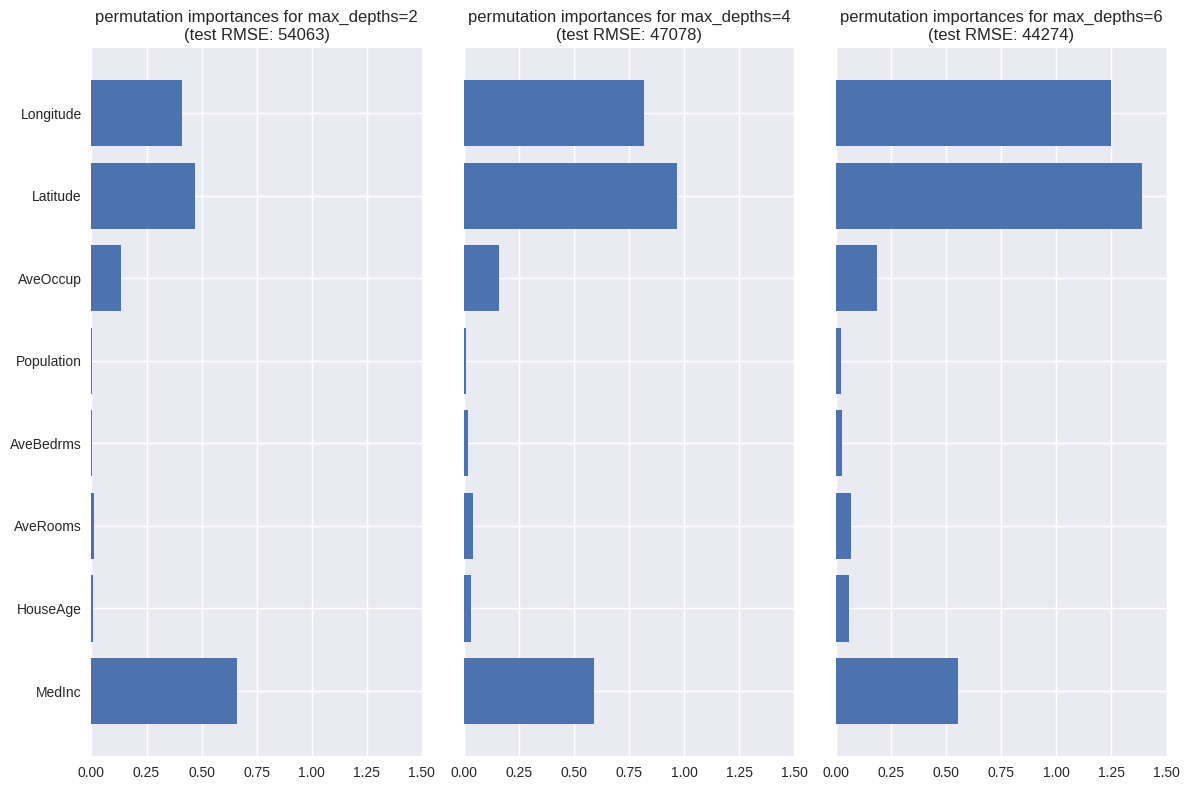

In [62]:
# %%
# Aside: Checking the importance of longitude and latitude as predictive features
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# %%
# Remember that earlier on, we formed the hypothesis that tree-based
# models would have difficulties making use of the longitude and latitude
# features because they require a high amount of splits to really be
# useful? Even if it’s not strictly necessary, let’s take some time to
# check this hypothesis.

# %%
# To do this, what we would want to do is to check how much the tree-based model
# relies on said features, given that we change the depth of the tree. To
# determine the importance of the feature, we will use the
# :func:`sklearn.inspection.permutation_importance` function from sklearn. Then
# we would like to check if longitude and latitude become more important if we
# increase the depth of the decision trees.

# %%
# Be aware that we don’t want to use the ``StackingRegressor`` with
# the KNN predictions here, because for that model, the longitude and
# latitude influence the KNN prediction feature, obfuscating the result.
# So let’s use the pure ``GradientBoostingRegressor`` here.

# %%
# Our approach will be to train 3 models with different values for
# ``max_depth``. We choose relative small values here because
# gradient boosting typically uses very shallow trees (the default depth
# is 3). After training, we calculate the permutation importances of each
# feature and create a bar plot of the results:

# %%
max_depths = [2, 4, 6]
fig, axes = plt.subplots(1, 3, figsize=(12, 8))
for md, ax in zip(max_depths, axes):
    gb = GradientBoostingRegressor(max_depth=md, random_state=0)
    gb.fit(df_train, y_train)
    pi = permutation_importance(gb, df_train, y_train, random_state=0)
    score = -get_scorer("neg_root_mean_squared_error")(gb, df_test, y_test)

    ax.barh(df_train.columns, pi["importances_mean"])
    ax.set_xlim([0, 1.5])
    title = f"permutation importances for max_depths={md}\n(test RMSE: {score:.0f})"
    ax.set_title(title)
    if md > max_depths[0]:
        ax.set_yticklabels([])
plt.tight_layout()


# %%
# As we can see, longitude and latitude are not very important for
# ``max_depth=2``, even being below the importance of
# "MedInc". In contrast, they are more important for
# ``max_depth=4``, with the importance growing even more for
# ``max_depth=6``. This confirms our hypothesis, though we should be
# aware that besides ``max_depth``, other hyper-parameters influence
# the effective number of splits we have, so in reality it’s not that
# simple.

# %%
# Out of curiosity, we also show the RMSE on the test set for the
# individual models. Interestingly, we find that its considerably worse
# than the scores we got earlier when we included the KNN predictions, not
# even beating the linear regression! This is a nice validation that our
# KNN feature really helps a lot.

# %%
# Final model
# ^^^^^^^^^^^

In [63]:
# %%
# Let’s settle on a final model for now. We will use gradient boosting
# again, only this time using more estimators. In general, with gradient
# boosting, more trees help more. The tradeoff is mostly that the
# resulting model will be bigger and slower. We go with 500 trees here
# (the default is 100), but ideally we should run a hyper-parameter search
# to get the best results.

# %%
gb_final = StackingRegressor(
    estimators=knn_regressor,
    final_estimator=GradientBoostingRegressor(n_estimators=500, random_state=0),
    passthrough=True,
)

In [64]:
# %%
gb_final.fit(df_train, y_train)

# %%
-get_scorer("neg_root_mean_squared_error")(gb_final, df_test, y_test)


40709.24898984372

In [65]:
# %%
# The final RMSE is a bit better than we got earlier when using 100 trees,
# while the training time is still reasonably fast, so we can be happy
# with the outcome.

# %%
# Sharing the model
# -----------------

# %%
# Saving the model artifact
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# %%
# Now that we trained the final model, we should save it for later usage.
# We could use pickle (or joblib) to do this, and there’s nothing wrong
# with that. However, the resulting file is insecure because it can
# theoretically execute arbitrary code when loading. Thus, if we want to
# share this models with other people, they might be reluctant to unpickle
# the file if they don’t trust us completely.

# %%
# An alternative to the pickle format is the skops format. It is built
# with security in mind, therefore, other people can open your skops file
# without worries, even if they don’t trust us. More on the skops format
# can be found
# `here <https://skops.readthedocs.io/en/stable/persistence.html>`__.

# %%
# For the purpose of this exercise, let’s use skops by calling
# ``skops.io.dump`` (``skops.io`` was imported as
# ``sio``) and store the model in a temporary directory, as shown
# below:


# %%
temp_dir = Path(mkdtemp())
file_name = temp_dir / "model.skops"

# %%
sio.dump(gb_final, file_name)


In [66]:
# %%
# Creating a model card
# ~~~~~~~~~~~~~~~~~~~~~

# %%
# When we want to share the model with others, it’s good practice to add a
# model card. That way, interested users can quickly learn what to expect.

# %%
# As a first approximation, a model card is a text document, often written
# in markdown, that contains sections talking about what kind of problem
# we’re dealing with, what kind of model to is used, what the intended
# purpose is, how to contact the authors, etc. It may also contain some
# metadata, which is targeted at machines and contains, say, tags that
# indicate what type of model or task being used. For now, we start
# without metadata.

# %%
# To help getting started, we can use the ``skops.card.Card`` class.
# It comes with a few default sections and provides some convenient
# methods for adding figures etc. The
# `documentation <https://skops.readthedocs.io/en/stable/model_card.html>`__
# goes into more details.

# %%
# For now, let’s start by creating a new model card and adding a few bits
# of information. We pass our final model as an argument to the
# ``Card`` class, which is used to create a table of
# hyper-parameters and a diagram of the model.


# %%
model_card = card.Card(model=gb_final)
model_card


Card(
  model=StackingRegressor(estimators=[('kn... random_state=0), passthrough=True),
  Model description/Training Procedure/Hyperparameters=TableSection(50x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
)

In [69]:
# %%
# Next let’s add some prose the the model card. We add a short description
# of the model, the intended use, the data, and the preprocessing steps.
# Those are just plain strings, which we add to the card using the
# ``model_card.add`` method. That method takes ``**kwargs`` as
# input, where the key corresponds to the name of the section and the
# value corresponds to the content, i.e. the aforementioned strings. This
# way, we can add multiple new sections with a single method call.

# %%
description = """Gradient boosting regressor trained on California Housing dataset

The model is a gradient boosting regressor from sklearn. On top of the standard
features, it contains predictions from a KNN models. These predictions are calculated
out of fold, then added on top of the existing features. These features are really
helpful for decision tree-based models, since those cannot easily learn from geospatial
data."""
intended_uses = "This model is meant for demonstration purposes"
dataset_description = data.DESCR.split("\n", 1)[1].strip()
preproc_description = (
    "Rows where the target was clipped are excluded. Train/test split is random."
)


In [70]:
model_card.add(
    **{
        "Model description": description,
        "Model description/Dataset description": dataset_description,
        "Model description/Intended uses & limitations": intended_uses,
        "Model Card Authors": "Benjamin Bossan",
        "Model Card Contact": "benjamin@huggingface.co",
    }
)

Card(
  model=StackingRegressor(estimators=[('kn... random_state=0), passthrough=True),
  Model description=Gradient boosting regressor ...y learn from geospatial data.,
  Model description/Intended uses & limitations=This model is ...ration purposes,
  Model description/Training Procedure/Hyperparameters=TableSection(50x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  Model description/Dataset description=California Housing..., 33 (1997) 291-297,
  Model Card Authors=Benjamin Bossan,
  Model Card Contact=benjamin@huggingface.co,
)

In [71]:
# %%
# Maybe someone might wonder why we call ``model_card.add(**{…})``
# like this. The reason is the following. Normally, Python
# ``**\ kwargs`` are passed like this: ``foo(key=val)``. But
# we cannot use that syntax here, because the ``key`` would have to
# be a valid variable name. That means it cannot contain any spaces, start
# with a number, etc. But what if our section name contains spaces, like
# ``"Model description"``? We can still pass it as
# ``kwargs``, but we need to put it into a dict first. This is why
# we use the shown notation.

# %%
# By the way, if we wanted to change the content of a section, we could
# just add the same section name again and the value would be overwritten
# by the new content.

# %%
# Another useful thing for readers of the card to have is a small code
# snippet that shows how to load the model. To add this, we use the
# ``model_card.add_get_started_code`` method. We add a short
# description, but that’s optional, as well as the model format (remember,
# we used the skops format here) and the file name. Regarding the latter,
# since the file is saved in a temporary directory, we should strip that
# away from the name by calling ``file_name.name``, since another
# user would not have the file in the exact same temporary location.

# %%
model_card.add_get_started_code(
    description="Run the code below to load the model",
    model_format="skops",
    file_name=file_name.name,
)


Card(
  model=StackingRegressor(estimators=[('kn... random_state=0), passthrough=True),
  Model description=Gradient boosting regressor ...y learn from geospatial data.,
  Model description/Intended uses & limitations=This model is ...ration purposes,
  Model description/Training Procedure/Hyperparameters=TableSection(50x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  Model description/Dataset description=California Housing..., 33 (1997) 291-297,
  How to Get Started with the Model=Run the code below t...example_input"])) ```,
  Model Card Authors=Benjamin Bossan,
  Model Card Contact=benjamin@huggingface.co,
)

In [72]:
# %%
# Another convenience method we should make use of is the
# ``model_card.add_metrics`` method. This will store the metrics
# inside a table for better readability. Again, we pass multiple inputs
# using ``**kwargs``, and the ``description`` is optional.

# %%
model_card.add_metrics(
    description="Metrics are calculated on the test set",
    **{
        "Root mean squared error": -get_scorer("neg_root_mean_squared_error")(
            gb, df_test, y_test
        ),
        "Mean absolute error": -get_scorer("neg_mean_absolute_error")(
            gb, df_test, y_test
        ),
        "R²": get_scorer("r2")(gb, df_test, y_test),
    },
)

Card(
  model=StackingRegressor(estimators=[('kn... random_state=0), passthrough=True),
  Model description=Gradient boosting regressor ...y learn from geospatial data.,
  Model description/Intended uses & limitations=This model is ...ration purposes,
  Model description/Training Procedure/Hyperparameters=TableSection(50x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  Model description/Evaluation Results=TableSection(3x2),
  Model description/Dataset description=California Housing..., 33 (1997) 291-297,
  How to Get Started with the Model=Run the code below t...example_input"])) ```,
  Model Card Authors=Benjamin Bossan,
  Model Card Contact=benjamin@huggingface.co,
)

<Axes: title={'center': 'House value by location'}, xlabel='Longitude', ylabel='Latitude'>

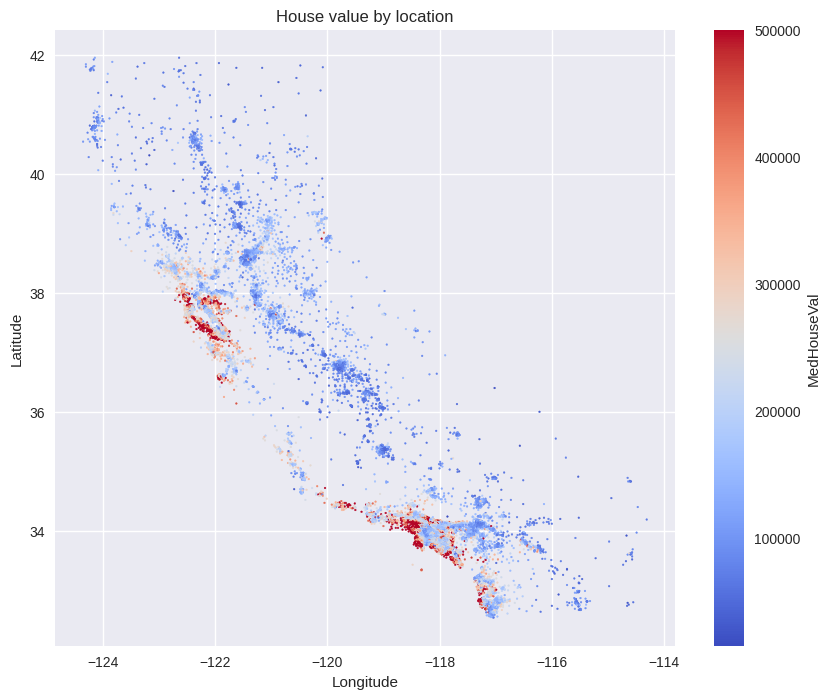

In [73]:
# %%
# How about we also add a plot to our model card? For this, let’s use the plot
# that shows the target as a function of longitude and latitude that we created
# above. We will just re-use the code from there to generate the plot. We will
# store it for now inside the same temporary directory as the model, then call
# the ``model_card.add_plot`` method. Since the plot is quite large, let’s
# collapse it in the model card by passing ``folded=True``.

# %%
fig, ax = plt.subplots(figsize=(10, 8))
df.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    c=target_col,
    title="House value by location",
    cmap="coolwarm",
    s=1.5,
    ax=ax,
)

In [74]:
fig.savefig(temp_dir / "geographic.png")
model_card.add_plot(
    folded=True,
    **{
        "Model description/Dataset description/Data distribution": "geographic.png",
    },
)

Card(
  model=StackingRegressor(estimators=[('kn... random_state=0), passthrough=True),
  Model description=Gradient boosting regressor ...y learn from geospatial data.,
  Model description/Intended uses & limitations=This model is ...ration purposes,
  Model description/Training Procedure/Hyperparameters=TableSection(50x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  Model description/Evaluation Results=TableSection(3x2),
  Model description/Dataset description=California Housing..., 33 (1997) 291-297,
  Model description/Dataset description/Data distribution=PlotSecti...aphic.png),
  How to Get Started with the Model=Run the code below t...example_input"])) ```,
  Model Card Authors=Benjamin Bossan,
  Model Card Contact=benjamin@huggingface.co,
)

Card(
  model=StackingRegressor(estimators=[('kn... random_state=0), passthrough=True),
  Model description=Gradient boosting regressor ...y learn from geospatial data.,
  Model description/Intended uses & limitations=This model is ...ration purposes,
  Model description/Training Procedure/Hyperparameters=TableSection(50x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  Model description/Evaluation Results=TableSection(3x2),
  Model description/Dataset description=California Housing..., 33 (1997) 291-297,
  Model description/Dataset description/Data distribution=PlotSecti...aphic.png),
  How to Get Started with the Model=Run the code below t...example_input"])) ```,
  Model Card Authors=Benjamin Bossan,
  Model Card Contact=benjamin@huggingface.co,
  Permutation Importances=PlotSection(permutation-importances.png),
)

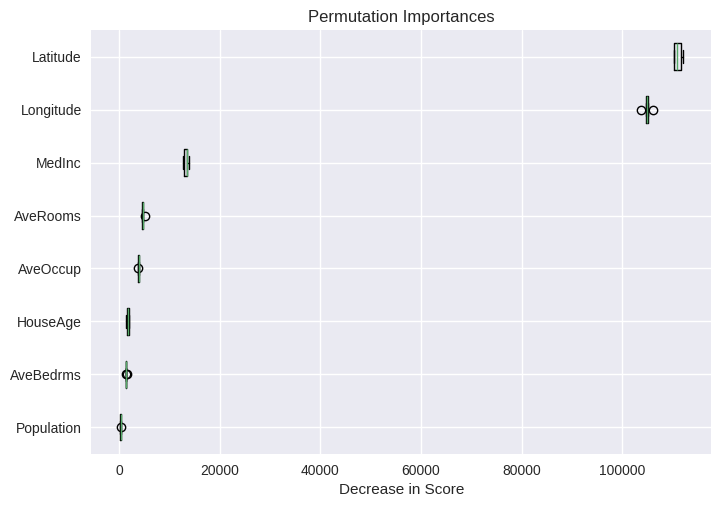

In [75]:
# %%
# Similar to the getting started code, we make sure that the file name we
# use for adding is just the plain ``"geographic.png"``,
# excluding the temporary directory, or else the file cannot be found
# later on.

# %%
# The model card class also provides a convenient method to add a plot
# that visualizes permutation importances. Let’s use it:

# %%
pi = permutation_importance(
    gb_final, df_test, y_test, scoring="neg_root_mean_squared_error", random_state=0
)
model_card.add_permutation_importances(
    pi, columns=df_test.columns, plot_file="permutation-importances.png", overwrite=True
)


In [76]:
# %%
# For this particular model card, the predefined section
# ``"Citation"`` is not required. Therefore, we delete it
# using ``model_card.delete``. Be careful: If there were subsections
# inside this section, they would be deleted too.


# %%
model_card.delete("Citation")


In [77]:
# %%
# Finally, we save the model card in the temporary directory as
# ``README.md``.

# %%
model_card.save(temp_dir / "README.md")

In [78]:
# %%
# Now the model card is saved as a markdown file in the temporary
# directory, together with the gradient boosting model and the figures we
# added earlier. We could now share the contents of that folder with
# people who might be interested in our model by sending them the contents
# of that directory.

# %%
# Upload the model to Hugging Face Hub
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# %%
# A perhaps better way to share these results is to upload it somewhere
# for other people to discover and use. Hugging Face provides a platform
# for doing this, the `Hugging Face
# Hub <https://huggingface.co/docs/hub/index>`__. Even though it’s mostly
# known for deep learning models, it also works with scikit-learn. So
# let’s upload our model and model card there.

# %%
# First, let’s create yet another temporary directory. This one will
# contain everything we want to upload to the Hugging Face Hub repository:

# %%
hub_dir = Path(mkdtemp())

In [79]:
# %%
# Next we use the ``hub_utils`` provided by skops to initialize and
# push the repository. For now, let’s create the initial repo using
# ``hub_utils.init``. Note that we pass the full path to the model
# file here. We also pass the requirements (which are scikit-learn,
# pandas, and skops in this case), the kind of task we’re solving,
# i.e. tabular regression, and a sample of our data (only the first 3 rows
# will actually be used).

# %%
requirements = [
    f"scikit-learn=={sklearn.__version__}",
    f"pandas=={pd.__version__}",
    f"skops=={skops.__version__}",
]

hub_utils.init(
    model=file_name,
    requirements=requirements,
    dst=hub_dir,
    task="tabular-regression",
    data=df_test,
)

In [80]:
# %%
# When we take a look at the directory of the repo, we find the following:

# %%
os.listdir(hub_dir)

['model.skops', 'config.json']

In [81]:
# %%
# So the model was automatically copied to the directory (which is why we
# needed to pass the full path to it), and a ``config.json`` was
# created, which contains useful metadata about our model.

# %%
# Remember that we can attach the metadata to our model card? Let’s do
# this now. To achieve this, we load the metadata from the
# ``config.json`` using the function ``metadata_from_config``
# that is provided by skops:

# %%
metadata = card.metadata_from_config(hub_dir / "config.json")
metadata

{'base_model': None, 'datasets': None, 'eval_results': None, 'language': None, 'library_name': 'sklearn', 'license': None, 'license_name': None, 'license_link': None, 'metrics': None, 'model_name': None, 'pipeline_tag': None, 'tags': ['sklearn', 'skops', 'tabular-regression'], 'model_format': 'skops', 'model_file': 'model.skops', 'widget': [{'structuredData': {'AveBedrms': [0.9290780141843972, 0.9458483754512635, 1.087360594795539], 'AveOccup': [3.1134751773049647, 3.0613718411552346, 3.2657992565055762], 'AveRooms': [6.304964539007092, 6.945848375451264, 3.8884758364312266], 'HouseAge': [17.0, 15.0, 24.0], 'Latitude': [34.23, 36.84, 34.04], 'Longitude': [-117.41, -119.77, -118.3], 'MedInc': [6.1426, 5.3886, 1.7109], 'Population': [439.0, 848.0, 1757.0]}}]}

In [82]:
# %%
# Let’s attach the metadata to our model card and save it again:

# %%
model_card.metadata = metadata
model_card.save(temp_dir / "README.md")

In [83]:
# %%
# So now the ``README.md`` contains the metadata. However, the model
# card and the figures we created are not part of the repository directory
# yet, they are still in the temporary directory we created earler. So
# let’s fix this. We use the ``add_files`` function to do this:

# %%
hub_utils.add_files(
    temp_dir / "README.md",
    temp_dir / "geographic.png",
    "permutation-importances.png",
    dst=hub_dir,
)

In [84]:
# %%
os.listdir(hub_dir)


['permutation-importances.png',
 'geographic.png',
 'model.skops',
 'README.md',
 'config.json']

# %%
# Creating the Repo and Pushing to Hugging Face Hub
# You can use the tools available in ``huggingface_hub`` to create a repo and
# push the contents of the repo folder to that repo. For more information visit
# https://huggingface.co/docs/huggingface_hub/index

# %%
# Conclusion
# ----------

# %%
# Hopefully, this has been a useful exercise. We took a deep dive into the
# task of working with the California Housing dataset, gained a good
# understanding of the data, used some of the more advanced and less well
# known features of scikit-learn, and trained a machine learning model
# that performs well.

# %%
# But we didn’t stop there. We also leveraged skops and the Hugging Face
# Hub to share our results with a wider public, ensuring that the model
# artifact is safe to use and that our task is well documented.

# %%
# If you have any feedback or suggestions for improvement, feel free to
# reach out to the skops team, e.g. by visiting our `discord
# channel <https://skops.readthedocs.io/en/stable/community.html#discord>`__.